# Assignment 3 - Tyler Teufel



## Step 1- setup
Imports, Dataset download, column refinement.

### Imports

In [ ]:
# General libraries
import numpy as np
import pandas as pd
import kagglehub
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score


# Keras for tokenization, padding, and model creation
!pip install tensorflow

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM



# Visualization
import matplotlib.pyplot as plt

### Download imbd dataset, adjust columns

In [ ]:

# Download the imdb dataset.
path = kagglehub.dataset_download("PromptCloudHQ/imdb-data")
print("Path to dataset files:", path)
print()

# List all files in the dataset directory.
files = os.listdir(path)
print("Files in dataset directory:", files)
print()

# Adjust the file to only include columns relevant to the assignment.
csv_file_path = os.path.join(path, 'IMDB-Movie-Data.csv')
data = pd.read_csv(csv_file_path)
data = data[['Title','Genre','Description']]

# Print data columns, as well as the first movie's information.
print(data.columns)
print()
print(data['Title'][1])
print(data['Genre'][1])
print(data['Description'][1])

Path to dataset files: /root/.cache/kagglehub/datasets/PromptCloudHQ/imdb-data/versions/1

Files in dataset directory: ['IMDB-Movie-Data.csv']

Index(['Title', 'Genre', 'Description'], dtype='object')

Prometheus
Adventure,Mystery,Sci-Fi
Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone.


## Step 2 - Preprocessing Step

### Begin tokenization + lemmatization with stop words

In [ ]:
# Download the three NLTK datasets for prepropressing.
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Create a set containing all of the english stop words to be used.
stop_words = set(stopwords.words('english'))
#print(stop_words)

# Create an instance of the WordNet Lemmatizer model.
lemmatizer = WordNetLemmatizer()

# Function for preprocessing each description.
def preprocess_text(description):

  # Tokenize the description inputted.
  tokens = nltk.word_tokenize(description.lower())


  # Use list comprehension to lemmatize non stop-word tokens containing
  # exclusively alphanumeric charcters.
  filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens
                     if token not in stop_words and token.isalnum()]
  return ' '.join(filtered_tokens)


# Apply the preprocess function to all descriptions, print out first example.
data['Description'] = data['Description'].apply(preprocess_text)
print(data['Description'][1])



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


following clue origin mankind team find structure distant moon soon realize alone


### 'Tokenize' the data by converting the cleaned text into integer sequences

In [ ]:
# Initialize an instance of the tokenizer.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Description'])

# Convert text to sequences of ints.
seq = tokenizer.texts_to_sequences(data['Description'])

# Get a dictionary of the word indices.
word_index = tokenizer.word_index

# Take the size of the total words, adding pad token.
vocab_size = len(word_index) + 1
print("Vocabulary Size:", vocab_size)


Vocabulary Size: 5149


### Padding Step

In [ ]:
# Preset max length to 100.
max_len = 100

# Set X equal to the padded sequence of ints, padded with 0s.
X = pad_sequences(seq, maxlen=max_len, padding='post')

print(f"Shape of X: {X.shape}")


Shape of X: (1000, 100)


## Step 3 - Load in and prepare the Embedding Matrix + GloVe

### Multi-Labelling by genres

In [ ]:
# Modify the Genre column to contain list of genres rather than a string.
data['Genre'] = data['Genre'].apply(lambda x: x.split(','))

# Instantiate the MultiLabelBinarizer object.
mlb = MultiLabelBinarizer()

# Set Y equal to the transformed data fit using the multi label
# binarizer.
Y = mlb.fit_transform(data['Genre'])
print(Y[0])
print(mlb.classes_)

[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
['Action' 'Adventure' 'Animation' 'Biography' 'Comedy' 'Crime' 'Drama'
 'Family' 'Fantasy' 'History' 'Horror' 'Music' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Sport' 'Thriller' 'War' 'Western']


### Data Splitting

In [ ]:
# Split the data based on the instructions.
X_train, Y_train = X[:700], Y[:700]
X_val, Y_val = X[700:800], Y[700:800]
X_test, Y_test = X[800:], Y[800:]

print("Training Data Shapes:")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

print("\nValidation Data Shapes:")
print("X_val:", X_val.shape)
print("Y_val:", Y_val.shape)

print("\nTest Data Shapes:")
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

Training Data Shapes:
X_train: (700, 100)
Y_train: (700, 20)

Validation Data Shapes:
X_val: (100, 100)
Y_val: (100, 20)

Test Data Shapes:
X_test: (200, 100)
Y_test: (200, 20)


### Load GloVe Embedding In

In [ ]:
# Commands to download the Glove embedding.
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


# Create empty dictionary to store word vectors.
embeddings_index = {}

# Open glove.6B.100d.txt and parse lines to extract word vectors.
with open('glove.6B.100d.txt', encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))


# Prepare the embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
  if i < vocab_size:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

print("Shape of Embedding Matrix:", embedding_matrix.shape)


--2024-11-17 21:38:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-17 21:38:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-17 21:38:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Step 4 - Build Models

### Building the RNN Model

In [ ]:
# Build RNN model
model_rnn = Sequential([Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                              input_length=max_len, weights=[embedding_matrix],
                              trainable=False), SimpleRNN(128),
                              Dense(20, activation='sigmoid')])

model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_rnn = model_rnn.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.0372 - loss: 0.6046 - val_accuracy: 0.1500 - val_loss: 0.3467
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.1966 - loss: 0.3321 - val_accuracy: 0.1500 - val_loss: 0.3228
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2193 - loss: 0.3200 - val_accuracy: 0.1500 - val_loss: 0.3225
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2047 - loss: 0.3213 - val_accuracy: 0.1500 - val_loss: 0.3205
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.2116 - loss: 0.3186 - val_accuracy: 0.1500 - val_loss: 0.3206
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1956 - loss: 0.3220 - val_accuracy: 0.1500 - val_loss: 0.3215
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.1708 - loss: 0.3213 - val_accuracy: 0.1500 - val_loss: 0.3197
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2005 - loss: 0.3169 - val_accuracy: 0.1500 - v

### LSTM Model

In [ ]:
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,
              weights=[embedding_matrix], trainable=False),
    LSTM(128),
    Dense(20, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=32)


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.1998 - loss: 0.6238 - val_accuracy: 0.1500 - val_loss: 0.3343
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.1986 - loss: 0.3242 - val_accuracy: 0.1500 - val_loss: 0.3195
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.1892 - loss: 0.3098 - val_accuracy: 0.1500 - val_loss: 0.3195
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.2081 - loss: 0.3184 - val_accuracy: 0.1500 - val_loss: 0.3203
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.2045 - loss: 0.3152 - val_accuracy: 0.1500 - val_loss: 0.3212
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.2014 - loss: 0.3141 - val_accuracy: 0.1500 - val_loss: 0.3213
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - accuracy: 0.1987 - loss: 0.3182 - val_accuracy: 0.1500 - val_loss: 0.3207
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.1695 - loss: 0.3161 - val_accuracy: 0.

## Step 5 - Evaluation of models

In [ ]:
# Evaluate RNN
test_loss_rnn, test_accuracy_rnn = model_rnn.evaluate(X_test, Y_test)
print(f"RNN Test Loss: {test_loss_rnn}, Test Accuracy: {test_accuracy_rnn}")

# Evaluate LSTM
test_loss_lstm, test_accuracy_lstm = model_lstm.evaluate(X_test, Y_test)
print(f"LSTM Test Loss: {test_loss_lstm}, Test Accuracy: {test_accuracy_lstm}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2011 - loss: 0.3184
RNN Test Loss: 0.31691333651542664, Test Accuracy: 0.2150000035762787
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.2011 - loss: 0.3178
LSTM Test Loss: 0.31583863496780396, Test Accuracy: 0.2150000035762787


## Step 6 - Plot Metrics

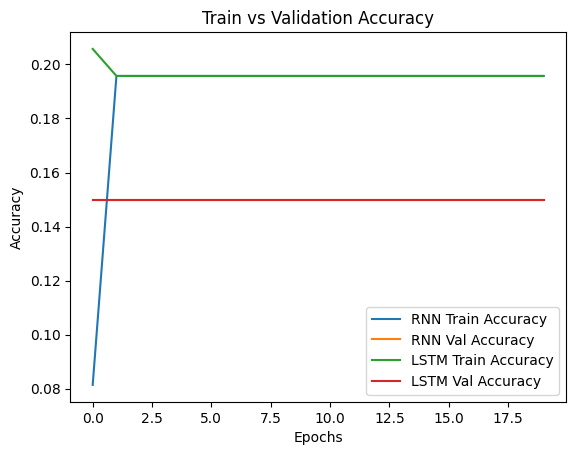

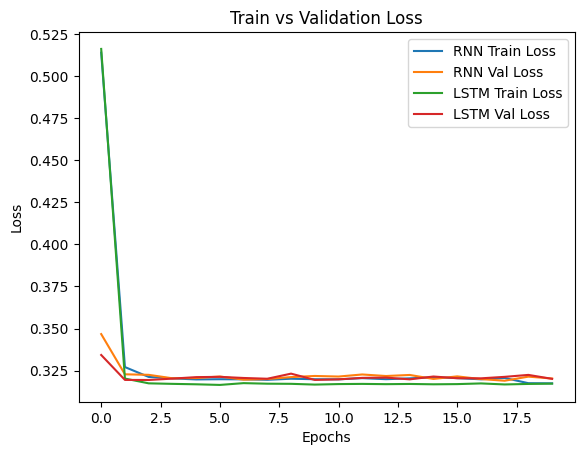

In [ ]:
# Plot accuracy for RNN and LSTM
plt.plot(history_rnn.history['accuracy'], label='RNN Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val Accuracy')
plt.plot(history_lstm.history['accuracy'], label='LSTM Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss for RNN and LSTM
plt.plot(history_rnn.history['loss'], label='RNN Train Loss')
plt.plot(history_rnn.history['val_loss'], label='RNN Val Loss')
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Val Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 7 - Add in Movie Titles

In [ ]:
# Combine Title and Description
data['Combined'] = data['Title'] + " " + data['Description']

# Refit tokenizer on the combined column
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Combined'])
sequences_combined = tokenizer.texts_to_sequences(data['Combined'])

# Rebuild padded sequences
X_combined = pad_sequences(sequences_combined, maxlen=max_len, padding='post')

X_train_combined, Y_train = X_combined[:700], Y[:700]
X_val_combined, Y_val = X_combined[700:800], Y[700:800]
X_test_combined, Y_test = X_combined[800:], Y[800:]
# Update vocabulary size
vocab_size = len(tokenizer.word_index) + 1


# Create a new embedding matrix for the combined vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)  # Retrieve GloVe vector
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
    LSTM(128),
    Dense(20, activation='sigmoid')
])

print(f"Max index in X_combined: {X_combined.max()}")
print(f"Vocab size: {vocab_size}")

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the LSTM model for 20 epochs
history_combined = model_lstm.fit(
    X_train_combined, Y_train,
    validation_data=(X_val_combined, Y_val),
    epochs=20,
    batch_size=32
)

# Evaluate the model on the test set
test_loss_combined, test_accuracy_combined = model_lstm.evaluate(X_test_combined, Y_test)
print(f"Test Loss: {test_loss_combined}")
print(f"Test Accuracy: {test_accuracy_combined}")



Max index in X_combined: 5874
Vocab size: 5875
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 420ms/step - accuracy: 0.0294 - loss: 0.6191 - val_accuracy: 0.1500 - val_loss: 0.3312
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 274ms/step - accuracy: 0.1796 - loss: 0.3265 - val_accuracy: 0.1500 - val_loss: 0.3222
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.1742 - loss: 0.3168 - val_accuracy: 0.1500 - val_loss: 0.3193
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - accuracy: 0.1859 - loss: 0.3171 - val_accuracy: 0.1500 - val_loss: 0.3211
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.1926 - loss: 0.3191 - val_accuracy: 0.1500 - val_loss: 0.3189
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.2129 - loss: 0.3205 - val_accuracy: 0.1500 - val_loss: 0.3195
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.1927 - loss: 0.3181 - val_accuracy: 0.1500 - val_loss: 0.3239
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.1991 - loss: 0.3134 - val_accuracy: 0.1500 - val

## Step 8 - Plotting and Saving total Metrics

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Models and their evaluation metrics
models = ['RNN', 'LSTM', 'LSTM (Title + Description)']

# Test loss and accuracy from model evaluation
test_loss = [test_loss_rnn, test_loss_lstm, test_loss_combined]
test_accuracy = [test_accuracy_rnn, test_accuracy_lstm, test_accuracy_combined]

# Predictions for each model
y_pred_rnn = (model_rnn.predict(X_test) > 0.5).astype(int)
y_pred_lstm = (model_lstm.predict(X_test) > 0.5).astype(int)
y_pred_combined = (model_lstm.predict(X_test_combined) > 0.5).astype(int)

# Precision, Recall, and F1 Score for each model
precision = [
    precision_score(Y_test, y_pred_rnn, average='micro'),
    precision_score(Y_test, y_pred_lstm, average='micro'),
    precision_score(Y_test, y_pred_combined, average='micro')
]

recall = [
    recall_score(Y_test, y_pred_rnn, average='micro'),
    recall_score(Y_test, y_pred_lstm, average='micro'),
    recall_score(Y_test, y_pred_combined, average='micro')
]

f1 = [
    f1_score(Y_test, y_pred_rnn, average='micro'),
    f1_score(Y_test, y_pred_lstm, average='micro'),
    f1_score(Y_test, y_pred_combined, average='micro')
]

# Create a DataFrame for comparison
results_df = pd.DataFrame({
    'Model': models,
    'Test Loss': test_loss,
    'Test Accuracy': test_accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})

results_df.to_csv('model_evaluation.csv', index=False)
# Display the results
results_df.head()



7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step


,Model,Test Loss,Test Accuracy,Precision,Recall,F1 Score
0,RNN,0.316913,0.215,0.53,0.215447,0.306358
1,LSTM,0.315839,0.215,0.53,0.215447,0.306358
2,LSTM (Title + Description),0.314672,0.215,0.53,0.215447,0.306358
